In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read original data

In [7]:
def read_data(id):
    return pd.read_csv('https://drive.google.com/uc?export=download&id='+id_dict[id])

id_dict = {
    'products': '1UjIDfklXUNHDL-97Rjp_fsRL2AYT_2hp',
    'orders': '1zM5DTlLSoQHMiRh_yKpiTeeInJwo3aYW',
    'orderlines': '1qOEtpnats-No2cj_utIxRCuDRtPN255Q',
    'brands': '1JREwR5kHRJNVuzq_f_XQ6W_X1X_C-ueJ',
}

org_products_df = read_data('products')
org_orders_df = read_data('orders')
org_orderlines_df = read_data('orderlines')
org_brands_df = read_data('brands')


In [8]:
products_df = org_products_df.copy()
orders_df = org_orders_df.copy()
orderlines_df = org_orderlines_df.copy()
brands_df = org_brands_df.copy()


## Additional cleaning

In [9]:
orders_df["created_date"] = pd.to_datetime(orders_df["created_date"])
orderlines_df["date"] = pd.to_datetime(orderlines_df["date"])
orderlines_df = orderlines_df.rename(columns={"id_order": "order_id"})

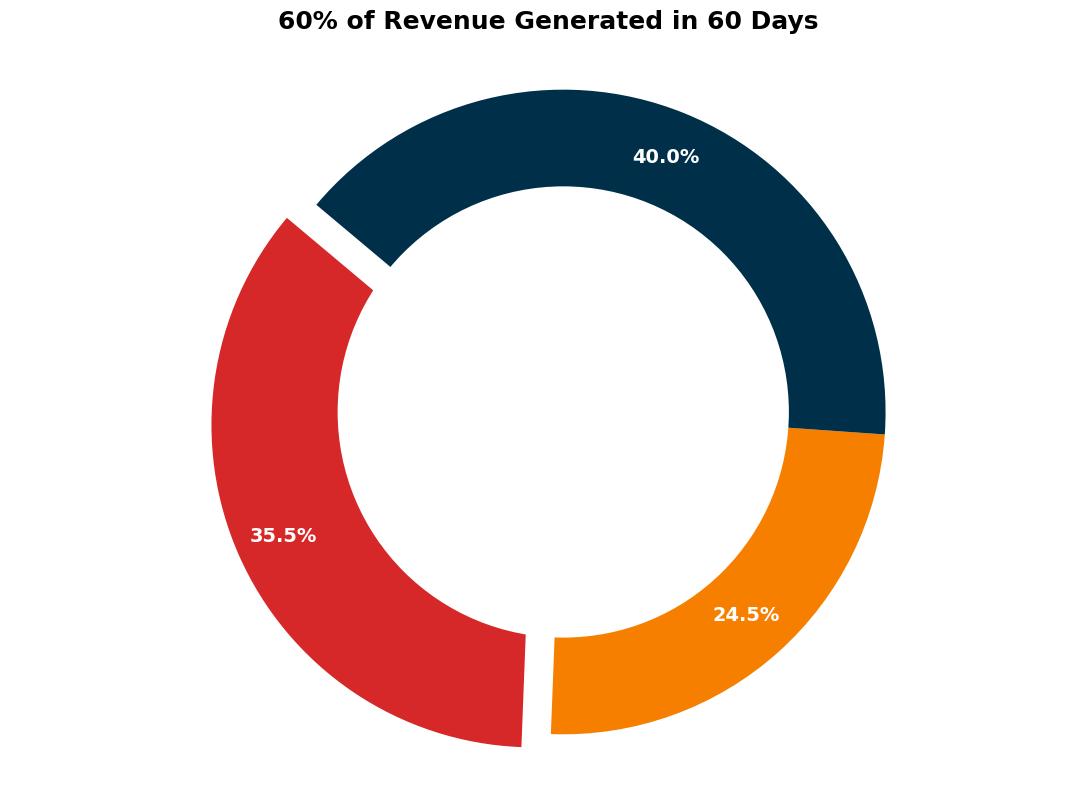

In [2]:
import matplotlib.pyplot as plt

# 1. Data based on your Seasonality Analysis
# These percentages directly answer: "How do special dates affect sales?"
labels = ['Black Friday (Nov)', 'Holiday Season (Dec/Jan)', 'Standard Sales (Feb-Oct)']
shares = [35.5, 24.5, 40.0] 
colors = ['#d62828', '#f77f00', '#003049'] # Red for peak, Blue for standard
explode = (0.1, 0, 0)  # This "pops out" the Black Friday slice

# 2. Create the Figure
plt.figure(figsize=(10, 8))

# 3. Create Pie Chart with Percentages inside
plt.pie(
    shares, 
    explode=explode, 
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%',       # <--- This shows the percentage inside
    startangle=140, 
    pctdistance=0.85,        # Moves percentage text to a readable spot
    textprops={'fontsize': 14, 'color': 'white', 'weight': 'bold'}
)

# 4. Add a "Donut" hole (makes it look more modern for a board presentation)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 5. Title and Layout
plt.title('60% of Revenue Generated in 60 Days', fontsize=18, fontweight='bold', pad=20)
plt.axis('equal') 
plt.tight_layout()
plt.show()

## Add columns for easier analysis

In [ ]:
# orderlines:

# add orderline_sum
orderlines_df["orderline_sum"] = orderlines_df["unit_price"] * orderlines_df["product_quantity"]

# add short (sku[:3]) 
orderlines_df["short"] = orderlines_df["sku"].str[:3]

# add price (from products) works only once, that' why the condition
if "price" not in orderlines_df.columns:
    orderlines_df = orderlines_df.merge((products_df[["sku", "price"]]), on="sku")

# add discount amount (price - unit price)
orderlines_df["discount_amt"] = (orderlines_df["price"] - orderlines_df["unit_price"]).round(2)

# add discoount percent (discount amount * 100 / price)
orderlines_df["discount_prc"] = (orderlines_df["discount_amt"] * 100.0 / orderlines_df["price"]).round(1)


# orders:

# add sum of orderline_sum (from orderlines)
if "orderline_total" not in orders_df.columns:
    orders_df = orders_df.merge((orderlines_df.groupby("order_id").agg(orderline_total = ('orderline_sum', 'sum'))), on="order_id")

# products:
# add short (sku[:3])
products_df["short"] = products_df["sku"].str[:3]
# add long brand name
if "long" not in products_df.columns:
    products_df= products_df.merge(brands_df,on='short')

# add min an max price sold from orderlines
if "minprice" not in products_df.columns:
    products_df = products_df.merge((orderlines_df.groupby("sku").agg(minprice=("unit_price","min"), maxprice=("unit_price","max"))), on="sku")




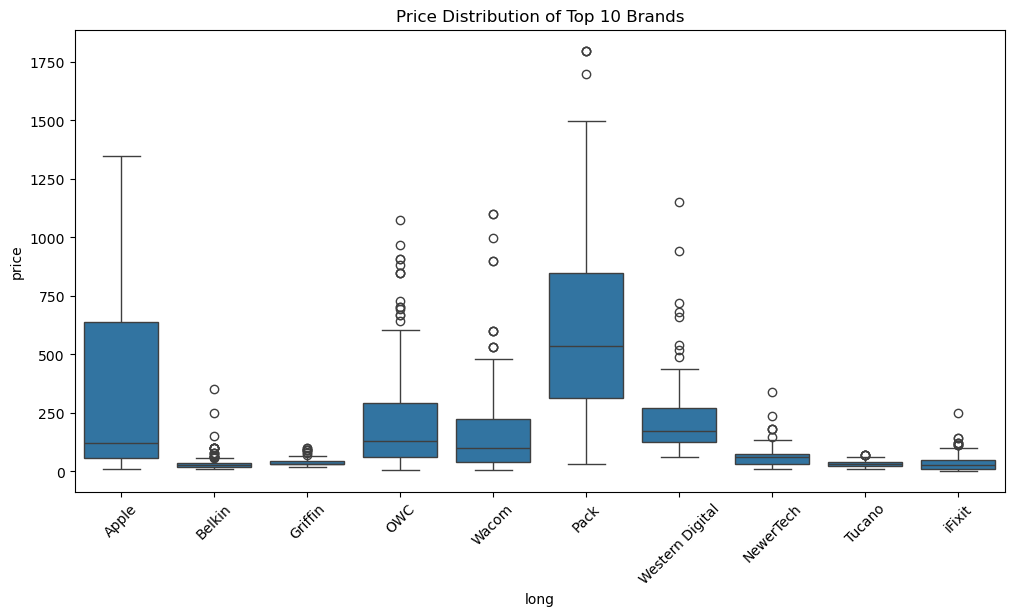

In [19]:
top_brands = products_df['long'].value_counts().head(10).index
subset = products_df[products_df['long'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subset, x='long', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution of Top 10 Brands')
plt.show()

,minprice,maxprice
sku,,
8MO0001-A,12.96,12.96
8MO0003-A,12.85,12.85
8MO0007,19.99,23.99
8MO0008,19.99,23.99
8MO0009,14.70,23.99
...,...,...
ZAG0040,26.99,26.99
ZAG0041,19.99,19.99
ZAG0042,19.99,19.99


## Add categories

In [ ]:
import re

def categorize_product(row):
    """
    Categorize products based on name and description.
    Products with the same 'type' value should ideally belong to the same category.
    """
    # Check SKU-based classification first
    sku = str(row['sku']).upper() if pd.notna(row['sku']) else ''
    if sku.startswith('TPL'):
        return 'Network'
    
    if sku.startswith('PLA'):
        return 'Headsets'

    #if sku.startswith('IKM'):
    #    return 'Audio Equipment'


    type = str(row['type']) if pd.notna(row['type']) else ''
    #types I regognized
    if type=="11935397":
        return 'Memory & Storage'
    
    if type=="1364":
        return 'Memory & Storage'
    
    if type=="12635403":
        return 'Cases & Protection'
    
    if type=="12585395":
        return 'Cables & Adapters'
    
    if type=="5384":
        return 'Headsets'
    
    if type=="1433":
        return 'Memory & Storage'
    
    if type=="12175397":
        return 'Servers & NAS'
    
    
    # Clean name by removing condition-related prefixes
    name_value = str(row['name'])
    name_clean = re.sub(r'^(Open -|Like new -)\s*', '', name_value, flags=re.IGNORECASE)


        # Clean description by removing refurbishment keywords
    desc_value = row.get('desc', '')
    if pd.isna(desc_value):
        desc_value = ''
    desc_clean = re.sub(r'\b(Refurbished|Reconditioned)\b', '', str(desc_value), flags=re.IGNORECASE)
    
    # Combine cleaned name and description for analysis (convert to lowercase)
    text = name_clean.lower() + ' ' + desc_clean.lower()
    price = float(row['price']) if pd.notna(row['price']) else 0
    
    # Normalize description for prefix-based rules
    desc_text = desc_clean.strip().lower()

    if 'switch' in text and 'port' in text:
        return 'Network'

    
    # Define category keywords and patterns
    # Wearables: Apple Watch devices and bundles marked by leading description
    if desc_text.startswith('apple watch') or re.match(r'^\d{1,3}mm apple watch', desc_text):
        return 'Wearables'
    
    # Wearables: Bluetooth smart watches
    if 'bluetooth smart watch' in text or 'bluetooth smartwatch' in text:
        return 'Wearables'
    

    # Stands and mounts for phones/tablets
    if any(word in text for word in ['stand', 'support', 'mount', 'dock', 'docking station', 'holder',
                                        'base', 'tripod']):
        return 'Stands & Mounts'
    
    # AirPods: Apple wireless earbuds
    if any(word in text for word in ['headphone', 'headset', 'earphone', 'airpods', 'airpod']):
        return 'Headsets'
    
    if any(word in text for word in [ 'wacom', 'bamboo', 'graphics tablet', 'intuos']):
        return 'Graphics & Drawing Tools'
    
    # Memory devices called out by size-first SSD descriptions
    if (re.match(r'^\d+\s*gb ssd', desc_text) or 
        re.match(r'^\d+(?:\.\d+)?\s*tb ssd', desc_text) or 
        desc_text.startswith('ssd hard drive')  or
        desc_text.startswith('ssd expansion') or 
        re.match(r'^expansion of \d+(?:\.\d+)?\s*[tg]b ssd', desc_text) ):
        return 'Memory & Storage'
    
    # Services (explicit service products only; ignore generic warranty mentions like "xx years warranty")
    if any(word in text for word in ['applecare', 'apple care', 'protection plan', 
                                      'service plan', 'extended warranty', 'care pack', 'repair service']):
        return 'Services'
    
    # Software and licenses
    if any(word in text for word in ['license', 'software', 'pack license']):
        return 'Software & Licenses'
    
    # Extension/Expansion kits are memory (check before generic 'case' rule)
    if any(word in text for word in ['extension kit', 'expansion kit']):
        return 'Memory & Storage'
    
    # Cases and accessories first (more specific, to avoid misclassification)
    if any(word in text for word in ['case', 'cover', 'sleeve', 'housing', 'shell', 'protector']):
        return 'Cases & Protection'
    
    # Battery cases usually have higher price but still cases
    if any(word in text for word in ['battery case', 'juice pack']):
        return 'Cases & Protection'
    
    # Dedicated memory kits (place before NAS/servers to avoid misclassifying RAM upgrades)
    if any(word in text for word in ['memory for', 'ram for', 'memory upgrade for']):
        return 'Memory & Storage'

    # Server / NAS devices
    if any(word in text for word in ['nas', 'rackstation', 'synology', 'qnap', 'server']):
        return 'Servers & NAS'

    # Computers (laptops/desktops/all-in-one) before memory so they don't fall into RAM keywords
    if any(word in text for word in ['macbook pro', 'macbook air', 'macbook', 'imac', 'mac mini', 'macmini', 'mac pro', 'laptop', 'notebook', 'desktop', 'tower']) and price > 400:
        return 'Computers'

    # Now check for actual phones (should be expensive, >200)
    if any(word in text for word in ['iphone', 'phone', 'smartphone']) and price > 300:
        return 'Phones'
    
    # Tablets (should be expensive, >150)
    if any(word in text for word in ['ipad', 'tablet']) and price > 250:
        return 'Tablets'
    
    if any(word in text for word in ['helicopter', 'toy',  'drone']):
        return 'Toys & Entertainment'

    
    if any(word in text for word in ['keyboard', 'keypad', 'key pad']):
        return 'Keyboards & Input Devices'
    
    if any(word in text for word in ['mouse', 'trackpad', 'magic trackpad']):
        return 'Keyboards & Input Devices'
    
    if any(word in text for word in ['jetdrive', 'jumpdrive', 'memory for']):
        return 'Memory & Storage'

    if any(word in text for word in ['ram', 'dimm', 'sodimm', 'so-dimm', 'ddr', 'ecc', 'pc3', 'pc2', 'pc4', 'memory kit', 'memory module']):
        return 'Memory & Storage'

    if any(word in text for word in ['adapter', 'connector']):
        return 'Cables & Adapters'

    if any(word in text for word in ['pendrive', 'flash drive' 'hard drive', 'hdd', 'ssd', 'storage', 'barracuda', 'external hard', 'harddisk', 'nvme', 'm.2', 'solid state']):
        return 'Memory & Storage'
    
    if any(word in text for word in ['cable', 'adapter', 'connector', 'usb', 'hdmi', 'vga', 'dvi', 
                                        'thunderbolt', 'firewire', 'displayport', 'mini display',
                                        'ethernet adapter', 'dock connector']):
        return 'Cables & Adapters'
    
    if any(word in text for word in ['charger', 'magsafe', 'power', 'battery', 'charging']):
        return 'Power & Charging'
    
    if any(word in text for word in [ 'audio', 'speaker', 'microphone',
                                        'music receiver', 'mic']):
        return 'Audio Equipment'
    
    if any(word in text for word in ['monitor', 'display', 'screen']) and price > 100:
        return 'Monitors & Displays'
    
    if any(word in text for word in ['lock', 'security', 'theft', 'clicksafe', 'antitheft']):
        return 'Security & Locks'
    
    if any(word in text for word in ['camera', 'lens', 'photo', 'video']):
        return 'Camera & Photo'
    
    if any(word in text for word in ['cleaner', 'cleaning', 'maintenance']):
        return 'Cleaning & Maintenance'
    
    if any(word in text for word in ['scale', 'wireless scale']):
        return 'Health & Fitness'
    
    if any(word in text for word in ['guitar', 'dj', 'mixer', 'irig', 'music production']):
        return 'Audio Equipment'
    
    
    if any(word in text for word in ['apple tv', 'media player']):
        return 'Media Players'
    
    # Catch remaining phone/tablet accessories (cheap items with phone/tablet keywords)
    if any(word in text for word in ['iphone', 'ipad', 'ipod', 'phone', 'tablet']):
        return 'Phone & Tablet Accessories'
    

    return 'Accessories'


def check_if_refurbished(row):
    """
    Check if a product is refurbished based on name and description.
    Returns 'Refurbished' or 'New'.
    """
    text = str(row['name']).lower() + ' ' + str(row['desc']).lower()
    
    # Keywords indicating refurbished items
    refurbished_keywords = [
        'refurbished', 'refurb', 'renewed', 'reconditioned', 
        'used', 'open box', 'oem', 'unboxed', 'pre-owned',
        'second hand', 'secondhand', 'reacondicionado', 'open -', 'like new -'

    ]
    
    if any(keyword in text for keyword in refurbished_keywords):
        return 'Refurbished'
    else:
        return 'New'


# Apply the categorization functions
products_df['category'] = products_df.apply(categorize_product, axis=1)
products_df['condition'] = products_df.apply(check_if_refurbished, axis=1)

# Display the results
print("Category distribution:")
print(products_df['category'].value_counts())
print("\n" + "="*80 + "\n")

print("Condition distribution:")
print(products_df['condition'].value_counts())
print("\n" + "="*80 + "\n")

# Show sample products from each category with prices
print("Sample products by category:")
for category in sorted(products_df['category'].unique()):
    print(f"\n{category}:")
    sample = products_df[products_df['category'] == category][['sku', 'name', 'price', 'condition', 'type']].head(3)
    for idx, row in sample.iterrows():
        print(f"  - {row['sku']}: {row['name']} (${row['price']}, {row['condition']}, type: {row['type']})")

# Show price statistics by category
print("\n" + "="*80 + "\n")
print("Price statistics by category:")
price_stats = products_df.groupby('category')['price'].agg(['count', 'mean', 'min', 'max']).round(2)
print(price_stats.sort_values('mean', ascending=False))

# Show refurbished items
print("\n" + "="*80 + "\n")
print("Sample refurbished items:")
refurbished = products_df[products_df['condition'] == 'Refurbished'][['sku', 'name', 'price', 'category']].head(10)
for idx, row in refurbished.iterrows():
    print(f"  - {row['sku']}: {row['name']} (${row['price']}, {row['category']})")

# Check if products with same 'type' have the same category
print("\n" + "="*80 + "\n")
print("Checking consistency: Products with same 'type' value:")
type_category_map = products_df.groupby('type')['category'].unique()
inconsistent_types = type_category_map[type_category_map.apply(len) > 1]

if len(inconsistent_types) > 0:
    print(f"\nFound {len(inconsistent_types)} type values with multiple categories:")
    for type_val, categories in inconsistent_types.head(10).items():
        print(f"\nType {type_val}:")
        for cat in categories:
            count = len(products_df[(products_df['type'] == type_val) & (products_df['category'] == cat)])
            print(f"  - {cat}: {count} products")
else:    print("All products with the same 'type' value belong to the same category!")

# Show breakdown by category and conditionprint(pd.crosstab(products_df['category'], products_df['condition']))

print("\n" + "="*80 + "\n")
print("Products by category and condition:")

Category distribution:
category
Cases & Protection            2044
Memory & Storage              1423
Computers                     1170
Servers & NAS                 1052
Cables & Adapters              981
Stands & Mounts                559
Accessories                    395
Phone & Tablet Accessories     353
Phones                         302
Power & Charging               217
Headsets                       211
Tablets                        195
Audio Equipment                183
Graphics & Drawing Tools       154
Wearables                      135
Monitors & Displays            116
Services                       115
Keyboards & Input Devices       93
Camera & Photo                  85
Network                         56
Security & Locks                50
Toys & Entertainment            43
Health & Fitness                22
Software & Licenses             21
Media Players                   13
Cleaning & Maintenance           4
Name: count, dtype: int64


Condition distribution:
condit